# Topic modeling on reddit comments

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook')
import os
import glob
import pickle
from operator import itemgetter
from datetime import datetime
from matplotlib.pyplot import cm 

In [2]:
def concat_submissions_comments(path_submissions, path_comments, filename_comments):
    all_files = glob.glob(os.path.join(path_submissions, 'part-*'))

    dfs = pd.concat([pd.read_csv(f) for f in all_files])
    dfs = dfs[dfs.num_comments != 0]

    comment_folder = glob.glob(os.path.join(path_comments, filename_comments))
    comments_files = [glob.glob(os.path.join(folder, "part-*")) for folder in comment_folder]
    comments_files_all = [file for sublist in comments_files for file in sublist]

    dfc = pd.concat([pd.read_csv(f) for f in comments_files_all])
    
    return dfs, dfc

In [3]:
def concat_comments_per_submission(x):
    return pd.Series(dict(comments=' '.join(x['body'])))

In [4]:
import nltk
import re
import string
from gensim import corpora, models
from nltk.corpus import stopwords
from many_stop_words import get_stop_words
from collections import defaultdict

def preprocessing(text):
       #################### Pre-processing ##################
    # Removing numbers
    text = [re.sub(r'\d+', '', t) for t in text]

    # Tokenization
    tokens = [nltk.word_tokenize(doc) for doc in text]
    text_tokens = nltk.Text(tokens)

    # Stop words removal
    extra_stop = set(("''", ",",":","...",".",";","``","\'","^|","la","en","le","et","ist",
                      "das","nicht","ich","zu","du","es","von","mit","auch","let","man",
                     "für", "den", "auf", "ein", "dass", "les", "que","un","pas"))
    stops = set(stopwords.words('english')).union(extra_stop)
    #Punctuation
    stops = set(stops).union(string.punctuation)
    #French Stopwords
    stops = set(stops).union(get_stop_words('fr'))
    #German Stopwords
    stops = set(stops).union(get_stop_words('de'))
    #Italian Stopwords
    stops = set(stops).union(get_stop_words('it'))


    filtered_text = [[word for word in t if str(word).lower() not in stops] for t in text_tokens]

    # Remove very frequent and very in-frequent words
    lower_freq = 10
    upper_freq = 1000    
    frequency = defaultdict(int)
    for text in filtered_text:
        for token in text:
            frequency[token] += 1
    texts = [[token for token in text if frequency[token] > lower_freq and frequency[token] < upper_freq and len(token) != 1]
             for text in filtered_text]

    # Removing documents less than minimum length
    min_length = 0
    long_texts = [text for text in texts if len(text)>=min_length]
    print("No. of documents: {}".format(len(long_texts)))
    return long_texts

def topic_modeling(texts, num_topics):


    ############## Topic modeling using LDA #################
    # Dictionary of all the words
    dictionary = corpora.Dictionary(texts)

    # Vector representation of each document
    corpus = [dictionary.doc2bow(text) for text in texts]

    # At this stage, dictionary contains the list of all words, each word with an unique integer id. 
    # 'corpus' contains for each document a bag of words representation (the number of occurrences of each word).

    model = models.LdaModel(corpus, num_topics, id2word=dictionary,passes=4,chunksize=1000)
    #model.print_topics()
    ########################################################

    return model, corpus, dictionary

/Users/vidit/anaconda3/envs/python35/lib/python3.5/site-packages/gensim/utils.py:1015: UserWarning: Pattern library is not installed, lemmatization won't be available.
  warnings.warn("Pattern library is not installed, lemmatization won't be available.")


## Switzerland

In [6]:
path_submissions = "../data/reddit_swiss_submissions_fullcorpus"
path_comments = '../data'
filename_comments = "reddit_swiss_comments_*"

[dfs_swiss, dfc_swiss] = concat_submissions_comments(path_submissions, path_comments, filename_comments)

In [7]:
dfsc_swiss = dfs_swiss.merge(dfc_swiss, how='inner', left_on='name', right_on='link_id')
cps_swiss = dfsc_swiss.groupby(by='name_x').apply(concat_comments_per_submission)
cps_swiss = cps_swiss.reset_index()

dfs_name = pd.DataFrame(dfs_swiss[['name', 'title', 'created_utc']])
df_aggcomments_swiss = dfs_name.merge(cps_swiss, how='inner', left_on='name', right_on='name_x')
del df_aggcomments_swiss['name_x']
df_aggcomments_swiss['title_comments'] = df_aggcomments_swiss.apply(lambda x: x['title']+' '+x['comments'], axis=1)
#df_aggcomments

In [8]:
text_swiss = [t for t in df_aggcomments_swiss['title_comments']]
pickle.dump(text_swiss,open('swiss_comments.pickle','wb'))

In [9]:
text_swiss = pickle.load(open('swiss_comments.pickle','rb'))
processed_text = preprocessing(text_swiss)


No. of documents: 4825


In [10]:
num_topics = 15

[model_swiss, corpus, dictionary] = topic_modeling(processed_text, num_topics)
model_swiss.print_topics()

[(0,
  '0.023*"Swisscom" + 0.017*"data" + 0.013*"internet" + 0.010*"ms" + 0.010*"network" + 0.009*"phone" + 0.008*"news" + 0.007*"using" + 0.007*"Orange" + 0.007*"reddit"'),
 (1,
  '0.018*"price" + 0.012*"cheaper" + 0.010*"prices" + 0.010*"ticket" + 0.010*"card" + 0.009*"online" + 0.008*".-" + 0.008*"order" + 0.008*"shop" + 0.007*"buying"'),
 (2,
  '0.010*"TV" + 0.007*"Billag" + 0.007*"trains" + 0.007*"watch" + 0.006*"SBB" + 0.005*"app" + 0.004*"radio" + 0.004*"phone" + 0.004*"website" + 0.004*"show"'),
 (3,
  '0.009*"learn" + 0.009*"speaking" + 0.006*"languages" + 0.006*"french" + 0.006*"Italian" + 0.005*"canton" + 0.005*"school" + 0.005*"culture" + 0.005*"dialect" + 0.004*"english"'),
 (4,
  '0.007*"lake" + 0.006*"weather" + 0.006*"snow" + 0.006*"summer" + 0.006*"night" + 0.006*"Lausanne" + 0.006*"area" + 0.006*"near" + 0.006*"town" + 0.005*"walk"'),
 (5,
  '0.013*"beautiful" + 0.012*"trip" + 0.011*"visit" + 0.010*"Lucerne" + 0.010*"Interlaken" + 0.010*"recommend" + 0.009*"Zermatt" +

In [14]:
most_likely_topic_per_doc = []
for text in processed_text:
    topic_per_doc = model_swiss.get_document_topics(dictionary.doc2bow(text))
    most_likely_topic_per_doc.append(max(topic_per_doc,key=itemgetter(1))[0])

df_aggcomments_swiss['topic_number'] = most_likely_topic_per_doc



In [15]:
dates = [datetime.fromtimestamp(t) for t in df_aggcomments_swiss['created_utc'].astype(int)]
df_aggcomments_swiss['dates'] = dates
month_dic = ['Jan','Feb','March','April','May','June','July','August','Sept','Oct','Nov','Dec']
# month_dic[str(df_aggcomments_swiss.dates.iloc[0].year)]
df_aggcomments_swiss['year'] = [str(df_aggcomments_swiss.dates.iloc[i].year) for i in range(len(df_aggcomments_swiss))]

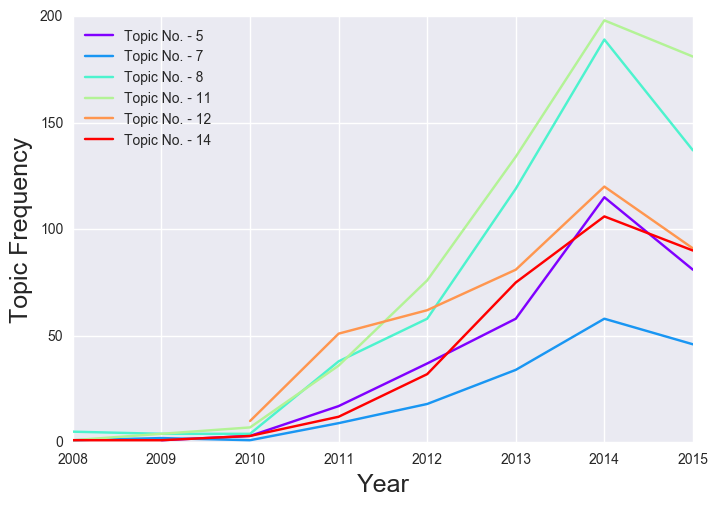

In [80]:
topic_freq_by_month_year = pd.DataFrame({'freq':df_aggcomments_swiss.groupby(['year','topic_number']).size()})
ddf = topic_freq_by_month_year.reset_index()

color=iter(cm.rainbow(np.linspace(0,1,6)))

interesting_topics = [11,12,14,8,5,7]
for group in ddf.groupby('topic_number'):
    if group[0] in interesting_topics:
        c=next(color)
        
        plt.plot(group[1].year.values,group[1].freq,c=c,label='Topic No. - %s' % group[0])
        plt.ticklabel_format(style='plain',axis='x')

plt.legend(loc=2)
plt.xticks(range(2008,2016),['2008','2009','2010','2011','2012','2013','2014','2015'])
plt.ylabel('Topic Frequency',fontsize=18)
plt.xlabel('Year',fontsize=18)

## UK

In [81]:
path_submissions = "../data/reddit_uk_submissions_fullcorpus"
path_comments = '../data'
filename_comments = "reddit_uk_comments_*"

[dfs_uk, dfc_uk] = concat_submissions_comments(path_submissions, path_comments, filename_comments)

In [82]:
del dfs_uk
del dfc_uk

In [12]:
dfsc_uk = dfs_uk.merge(dfc_uk, how='inner', left_on='name', right_on='link_id')
cps_uk = dfsc_uk.groupby(by='name_x').apply(concat_comments_per_submission)
cps_uk = cps_uk.reset_index()

dfs_name = pd.DataFrame(dfs_uk[['name', 'title']])
df_aggcomments_uk = dfs_name.merge(cps_uk, how='inner', left_on='name', right_on='name_x')
del df_aggcomments_uk['name_x']
df_aggcomments_uk['title_comments'] = df_aggcomments_uk.apply(lambda x: x['title']+' '+x['comments'], axis=1)
df_aggcomments_uk

KeyboardInterrupt: 

In [ ]:
text_uk = [t for t in df_aggcomments_uk['title_comments']]

In [ ]:
num_topics = 5
[model_swiss, corpus, dictionary, long_texts] = topic_modeling(text_uk, num_topics)
model_swiss.print_topics()

## EU

In [6]:
path_submissions = "../data/reddit_europe_submissions_fullcorpus"
path_comments = '../data'
filename_comments = "reddit_europe_comments_*"

[dfs_eu, dfc_eu] = concat_submissions_comments(path_submissions, path_comments, filename_comments)

In [9]:
sub_mention_swiss = pickle.load(open('../data/euro_swiss_mention_subs.pickle','rb'))
dfc_eu = dfc_eu[dfc_eu['link_id'].isin(sub_mention_swiss)]

In [11]:
dfsc_eu = dfs_eu.merge(dfc_eu, how='inner', left_on='name', right_on='link_id')
cps_eu = dfsc_eu.groupby(by='name_x').apply(concat_comments_per_submission)
cps_eu = cps_eu.reset_index()

dfs_name = pd.DataFrame(dfs_eu[['name', 'title', 'created_utc']])
df_aggcomments_eu = dfs_name.merge(cps_eu, how='inner', left_on='name', right_on='name_x')
del df_aggcomments_eu['name_x']
df_aggcomments_eu['title_comments'] = df_aggcomments_eu.apply(lambda x: x['title']+' '+x['comments'], axis=1)


In [14]:
text_eu = [t for t in df_aggcomments_eu['title_comments']]
processed_text = preprocessing(text_eu)


No. of documents: 343


In [16]:
num_topics = 15

[model_eu, corpus, dictionary] = topic_modeling(processed_text, num_topics)
model_eu.print_topics()

[(0,
  '0.012*"UK" + 0.009*"think" + 0.007*"get" + 0.007*"really" + 0.007*"much" + 0.007*"\'re" + 0.006*"education" + 0.006*"\'m" + 0.006*"school" + 0.005*"countries"'),
 (1,
  '0.011*"money" + 0.008*"one" + 0.007*"tax" + 0.007*"German" + 0.006*"Germany" + 0.005*"could" + 0.005*"http" + 0.005*"much" + 0.005*"even" + 0.005*"taxes"'),
 (2,
  '0.007*"French" + 0.007*"deleted" + 0.006*"think" + 0.006*"destruction" + 0.006*"one" + 0.005*"even" + 0.005*"still" + 0.005*"way" + 0.005*"conto" + 0.005*"Europe"'),
 (3,
  '0.010*"one" + 0.010*"deleted" + 0.008*"get" + 0.008*"http" + 0.007*"Germany" + 0.006*"\'m" + 0.006*"train" + 0.006*"\'re" + 0.006*"think" + 0.006*"need"'),
 (4,
  '0.021*"German" + 0.008*"Germany" + 0.008*"http" + 0.008*"tax" + 0.007*"one" + 0.006*"much" + 0.006*"speak" + 0.005*"\'m" + 0.005*"understand" + 0.005*"money"'),
 (5,
  '0.012*"genocide" + 0.012*"Schweiz" + 0.008*"one" + 0.008*"think" + 0.008*"deleted" + 0.008*"http" + 0.007*"really" + 0.006*"Turkey" + 0.006*"country" 

In [ ]:
germany_subreddit_list = ['germany', 'de', 'German', 'GermanPractice', 'GermanFacts', 'GermanConversation',                  ## germany
     'SCHLAND', 'germanyusa', 'DEjobs', 'bundesliga', 'GermanyPics', 'germusic', 'de_punk', 'germanrap', 'NDH']                 ## germany
france_subreddit_list  = ['blagues', 'cinemacinema', 'europe', 'france', 'FrancePics', 'frenchelectro', 'Frenchhistory', 'guessthefrenchmovie',      ## france
     'Ligue1', 'Livres', 'musiquefrancaise', 'paris', 'pedale', 'philosophie', 'Politique', 'rance', 'ScienceFr', 'SocialFrance']## france
italy_subreddit_list  = ['Calcio', 'ITAGLIA', 'Italianhistory', 'ITALIANMUSIC', 'italy', 'ItalyPhotos', 'Libri', 'Abruzzo', 'Apulia', 'bari',       ## italy
     'Basilicata', 'bologna', 'Calabria', 'Campania', 'Catania', 'emilia_romagna', 'firenze', 'friuli', 'Genova', 'Italia',     ## italy
     'lazio', 'Liguria', 'lombardia', 'Lombardy', 'marche', 'messina', 'milano', 'Modena', 'molise', 'Naples_Italy', 'napoli',  ## italy
     'padova', 'Palermo', 'Perugia', 'Piedmont', 'piemonte', 'Pisa', 'puglia', 'roma', 'rome', 'romesocialclub', 'Sardegna',    ## italy
     'Sardinia', 'Sicilia', 'sicily', 'Siracusa', 'torino', 'Toscana', 'trentino_alto_adige', 'trentod', 'Trieste',             ## italy
     'tuscany', 'Umbria', 'valle_daosta', 'Veneto', 'Venezia']                                                                 ## italy
spain_subreddit_list   =  ['Barcelona', 'EPANA', 'es', 'europe', 'futbol', 'Granada', 'LaLiga', 'Madrid', 'spain', 'Andalucia', 'SpanishHistory']     ## spain 

In [ ]:
dfs_germany = dfs_eu[dfs_eu['subreddit'].isin(germany_subreddit_list)]